#### Import Libraries

In [2]:
import numpy as np
import pandas as pd
import os
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Dropout, BatchNormalization, MaxPooling2D, Conv2D 
from tensorflow.keras.applications import EfficientNetB0
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow.keras.backend as K
from tensorflow.keras.layers import (
    Input, Dense, Flatten, Conv2D, MaxPooling2D,  
    Concatenate, Dropout
)
import matplotlib.pyplot as plt

#### Load Dataset

In [4]:

df = pd.read_csv(r"C:\Users\sbane\Desktop\Machine Learning\ML Project\Pet photos\train.csv")

# Extract metadata features and target variable
metadata_features = df.iloc[:, 1:-1].values  # Exclude ID and target column
pawpularity = df["Pawpularity"].values  # Target variable

# Normalize metadata features
scaler = StandardScaler()
metadata_features = scaler.fit_transform(metadata_features)


#### Train-Test Split

In [6]:
train_idx, val_idx = train_test_split(df.index, test_size=0.2, random_state=42)

# Split metadata using the indices
X_train_meta = metadata_features[train_idx]
X_val_meta = metadata_features[val_idx]
y_train = pawpularity[train_idx]
y_val = pawpularity[val_idx]

# Extract image IDs using the same split indices
train_image_ids = df.iloc[train_idx, 0].values  # Image IDs for training
val_image_ids = df.iloc[val_idx, 0].values  # Image IDs for validation

#### Load and Preprocess Images

In [8]:
IMG_SIZE = 224  # Image input size
IMG_PATH = r"C:\Users\sbane\Desktop\Machine Learning\ML Project\Pet photos\train"  
# Function to load and preprocess images
def load_images(image_ids, img_dir, img_size):
    images = []
    for img_id in image_ids:
        img_path = os.path.join(img_dir, img_id + ".jpg")  # Modify extension if needed
        if os.path.exists(img_path):  # Check if file exists
            img = cv2.imread(img_path)
            img = cv2.resize(img, (img_size, img_size))  # Resize image
            img = img / 255.0  # Normalize pixels
            images.append(img)
        else:
            print(f"Warning: Image {img_id}.jpg not found in {img_dir}")  # Debugging
            images.append(np.zeros((img_size, img_size, 3)))  # Placeholder for missing images
    return np.array(images)

# Load images for training and validation using correct indices
X_train_img = load_images(train_image_ids, IMG_PATH, IMG_SIZE)
X_val_img = load_images(val_image_ids, IMG_PATH, IMG_SIZE)

#### Verify Shapes to Prevent Errors

In [10]:
print(f"X_train_img shape: {X_train_img.shape}")  # Should match X_train_meta
print(f"X_train_meta shape: {X_train_meta.shape}")
print(f"y_train shape: {y_train.shape}")

print(f"X_val_img shape: {X_val_img.shape}")  # Should match X_val_meta
print(f"X_val_meta shape: {X_val_meta.shape}")
print(f"y_val shape: {y_val.shape}")

X_train_img shape: (7929, 224, 224, 3)
X_train_meta shape: (7929, 12)
y_train shape: (7929,)
X_val_img shape: (1983, 224, 224, 3)
X_val_meta shape: (1983, 12)
y_val shape: (1983,)


#### Define the CNN Model

In [12]:
# Define RMSE metric
def rmse(y_true, y_pred):
    y_true = K.cast(y_true, dtype="float32")
    y_pred = K.cast(y_pred, dtype="float32")
    return K.sqrt(K.mean(K.square(y_true - y_pred)))

# Define input image size
IMG_SIZE = 224  

# Define the CNN model
def build_model(input_meta_shape):
    # Image input
    image_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="Image_Input")

    # Convolutional layers with strides, padding, and pooling
    x = Conv2D(32, (3, 3), strides=(1, 1), padding="same", activation="relu")(image_input)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same")(x)

    x = Conv2D(64, (3, 3), strides=(1, 1), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same")(x)

    x = Conv2D(128, (3, 3), strides=(1, 1), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same")(x)

    x = Flatten()(x)

    # Metadata input
    metadata_input = Input(shape=(input_meta_shape,), name="Metadata_Input")
    y = Dense(32, activation="tanh")(metadata_input)
    y = Dropout(0.2)(y)

    # Combine image and metadata features
    combined = Concatenate()([x, y])
    z = Dense(64, activation="tanh")(combined)
    z = Dropout(0.2)(z)
    z = Dense(128, activation="tanh")(z)
    z = Dense(1, activation="linear")(z)  # Regression output

    # Define model
    model = Model(inputs=[image_input, metadata_input], outputs=z)
    
    # Compile model
    model.compile(optimizer="adam", loss="mse", metrics=[rmse])

    return model

# Assuming input_meta_shape is the number of metadata features
input_meta_shape = 12  # Update with actual metadata feature count
model = build_model(input_meta_shape)

# Print model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Image_Input (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 224, 224, 32)      │             896 │ Image_Input[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 224, 224, 32)      │             128 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 112, 112, 32)      │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 112, 112, 64)      │          18,496 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 112, 112, 64)      │             256 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 56, 56, 64)        │               0 │ batch_normalization_1[0][… │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 56, 56, 128)       │          73,856 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 56, 56, 128)       │             512 │ conv2d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Metadata_Input (InputLayer)   │ (None, 12)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 28, 28, 128)       │               0 │ batch_normalization_2[0][… │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 32)                │             416 │ Metadata_Input[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten (Flatten)             │ (None, 100352)            │               0 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 32)                │               0 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 100384)            │               

 Total params: 6,527,649 (24.90 MB)

 Trainable params: 6,527,201 (24.90 MB)

 Non-trainable params: 448 (1.75 KB)

#### Train the Model

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping
early_stopping = EarlyStopping(
    monitor="val_loss",  # Stop if validation loss stops improving
    patience=3,          # Wait for 3 epochs without improvement
    restore_best_weights=True  # Restore the best model
)

# Train the model with early stopping
history = model.fit(
    [X_train_img, X_train_meta], y_train,
    validation_data=([X_val_img, X_val_meta], y_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping]  
)

Epoch 1/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 461s 2s/step - loss: 916.1671 - rmse: 29.2925 - val_loss: 3432.5579 - val_rmse: 58.2804
Epoch 2/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 390s 2s/step - loss: 417.3481 - rmse: 20.1298 - val_loss: 490.7294 - val_rmse: 21.5355
Epoch 3/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 397s 2s/step - loss: 412.7334 - rmse: 20.0622 - val_loss: 442.0480 - val_rmse: 20.7287
Epoch 4/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 406s 2s/step - loss: 423.5989 - rmse: 20.2806 - val_loss: 442.0504 - val_rmse: 20.7241
Epoch 5/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 389s 2s/step - loss: 407.2757 - rmse: 19.8843 - val_loss: 442.2816 - val_rmse: 20.7437
Epoch 6/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 595s 2s/step - loss: 421.5599 - rmse: 20.2745 - val_loss: 442.1346 - val_rmse: 20.7359


#### Evaluate the Model

In [20]:
val_loss, val_rmse = model.evaluate([X_val_img, X_val_meta], y_val)
print(f"Validation RMSE: {val_rmse:.4f}")

62/62 ━━━━━━━━━━━━━━━━━━━━ 16s 246ms/step - loss: 434.8620 - rmse: 20.5805
Validation RMSE: 20.7287


#### Loss and RMSE Graphs

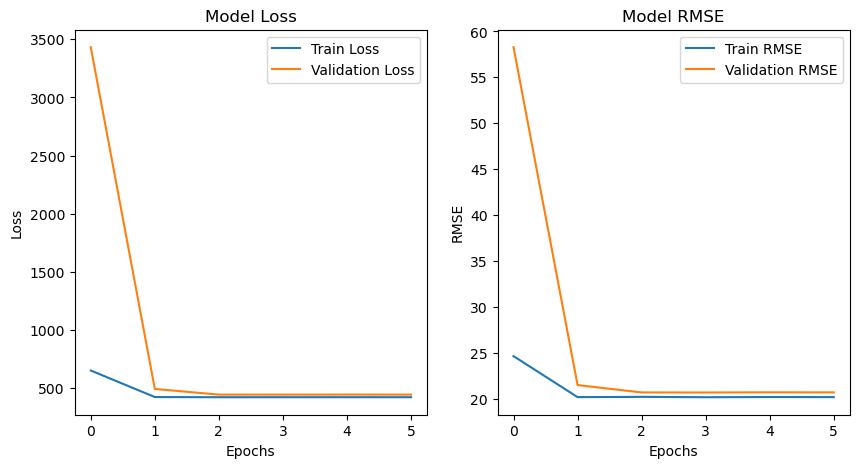

In [22]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['rmse'], label='Train RMSE')
plt.plot(history.history['val_rmse'], label='Validation RMSE')
plt.title('Model RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

plt.show()